In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import matplotlib.pyplot as plt
import sklearn
import os
import shap
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
data_path = '/Users/mkamruz/Public/SNL/Projects/5UTR/Data/Blend/'


/opt/miniconda3/envs/torch_cuda_128/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def shap_analysis_TreeModel(model, x_test):
    # --- Step 3: Calculate SHAP Values ---
    # Create a SHAP TreeExplainer object for tree-based models.
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values for the test set.
    # For binary classification, shap_values will be a list of two arrays.
    # `shap_values[0]` are for class 0, and `shap_values[1]` are for class 1.
    shap_values = explainer.shap_values(x_test)

    # --- Step 4: Generate SHAP Visualizations ---

    # --- Global Interpretation ---
    # 1. Summary Plot (Beeswarm)
    # This plot provides an overview of the most important features and their impact.
    # We plot for the positive class (class 1).
    print("Generating Summary Plot...")
    shap.summary_plot(shap_values[1], x_test, plot_type='violin', show=False)

def shap_analysis_LR(model, x_train, x_test):
    # Since Logistic Regression is not a tree model, we use KernelExplainer.
    # We pass a sample of the training data as the background dataset for the explainer.
    # KernelSHAP can be computationally slow, so using a small background sample is common.
    explainer = shap.KernelExplainer(model.predict_proba, x_train[:500], feature_names=x_train.columns)

    # Calculate SHAP values for the test set.
    # nsamples determines the number of times to sample for each explanation. Increase for more accuracy.
    shap_values = explainer.shap_values(x_test, nsamples=100)

    # --- shap visualization ---
    # Summary Plot (Beeswarm) for the positive class (class 1)
    print("Generating Summary Plot...")
    shap.summary_plot(shap_values)


def compute_metric(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:,1]
    #print(y_proba)

    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    # The .ravel() method flattens the 2D matrix into a 1D array
    tn, fp, fn, tp = cm.ravel()
    recall = sklearn.metrics.recall_score(
            y_test, y_pred, average="binary", zero_division=0
        )
    tnr = tn / (tn+fp) if (tn+fp)>0 else 0

    return {
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_pred),
        "f1": sklearn.metrics.f1_score(
            y_test, y_pred, average="binary", zero_division=0
        ),
        "precision": sklearn.metrics.precision_score(
            y_test, y_pred, average="binary", zero_division=0
        ),
        "recall": recall,
        "TNR": tnr,
        "AUC_ROC": sklearn.metrics.roc_auc_score(
            y_test, y_proba, multi_class='ovr', average='weighted')
    
    }

def search_param(opt_search, x_train, x_test, x_val, y_train, y_test, y_val, test_on, verbose=0):
    if verbose: print('Starting Bayesian hyperpatameter optimization')
    opt_search.fit(x_train, y_train)

    if verbose: print("Bayesian Optimization completed.")
    if verbose: print("Best hyperparameters found: ", opt_search.best_params_)
    if verbose: print("Best cross-validation score: {:.4f}".format(opt_search.best_score_))

    # Evaluate the best model on the test set
    best_model = opt_search.best_estimator_
    test_score = best_model.score(x_val, y_val)
    if verbose: print("Validation set accuracy with the best model: {:.4f}".format(test_score))
    perf = compute_metric(best_model, x_test, y_test)
    perf['test_on'] = test_on
    perf['Model'] = best_model.__class__.__name__
    perf['best_params'] = opt_search.best_params_
    del [opt_search, best_model]
    return perf

def LogisticRegressionModel(x_train, x_test, x_val, y_train, y_test, y_val, test_on, verbose=0):
    search_space={
        'C':Real(1e-6, 1e+6, prior='log-uniform'),
        'penalty': Categorical(['l1','l2']),
        'solver': Categorical(['liblinear'])
    }

    opt_search = BayesSearchCV(
        estimator=LogisticRegression(max_iter=10000),
        cv=10,
        search_spaces=search_space,
        n_iter=100,
        n_jobs=-1,
        random_state=43
    )

    return search_param(opt_search, x_train, x_test, x_val, y_train, y_test, y_val, test_on, verbose)

def RandomForestModel(x_train, x_test, x_val, y_train, y_test, y_val, test_on, verbose=0):
    search_space={
        'n_estimators':Integer(10, 200),
        'max_depth': Integer(2, 13)
    }

    opt_search = BayesSearchCV(
        estimator=RandomForestClassifier(random_state=43),
        cv=10,
        search_spaces=search_space,
        n_iter=100,
        n_jobs=-1,
        random_state=43
    )

    return search_param(opt_search, x_train, x_test, x_val, y_train, y_test, y_val, test_on, verbose)

def GradientBoostedModel(x_train, x_test, x_val, y_train, y_test, y_val, test_on, verbose=0):
    search_space={
        'n_estimators':Integer(10, 200),
        'max_depth': Integer(2, 13),
        'learning_rate': Real(1e-6, 1e+6, prior='log-uniform')
    }

    opt_search = BayesSearchCV(
        estimator=GradientBoostingClassifier(random_state=43),
        cv=10,
        search_spaces=search_space,
        n_iter=100,
        n_jobs=-1,
        random_state=43
    )

    return search_param(opt_search, x_train, x_test, x_val, y_train, y_test, y_val, test_on, verbose)

def XGBoostedModel(x_train, x_test, x_val, y_train, y_test, y_val, test_on, verbose=0):
    search_space={
        'n_estimators':Integer(10, 200),
        'max_depth': Integer(2, 13),
        'learning_rate': Real(1e-6, 1e+6, prior='log-uniform')
    }

    opt_search = BayesSearchCV(
        estimator=XGBClassifier(random_state=43),
        cv=10,
        search_spaces=search_space,
        n_iter=100,
        n_jobs=-1,
        random_state=43
    )

    return search_param(opt_search, x_train, x_test, x_val, y_train, y_test, y_val, test_on, verbose)


In [6]:
result = []
for p in ['mpra_data', 'cao2021/ratios/hek', 'cao2021/ratios/hek_muscle', 
              'cao2021/ratios/hek_muscle_pc3', 'cao2021/ratios/hek_pc3', 'cao2021/ratios/muscle', 
              'cao2021/ratios/muscle_pc3', 'cao2021/ratios/pc3']:
    test_on = p.split('/')[-1]

    print(f'Start training on [{test_on}]')

    fn = os.path.join(data_path, f"{test_on}.csv")
    df = pd.read_csv(fn)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:].values.ravel()
    del [df]

    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=43)
    x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,test_size=0.33,random_state=43)
    del [X, y]

    result.append(LogisticRegressionModel(x_train, x_test, x_val, y_train, y_test, y_val, test_on))
    result.append(RandomForestModel(x_train, x_test, x_val, y_train, y_test, y_val, test_on))
    result.append(GradientBoostedModel(x_train, x_test, x_val, y_train, y_test, y_val, test_on))
    result.append(XGBoostedModel(x_train, x_test, x_val, y_train, y_test, y_val, test_on))
    print(f'Finish training all models on [{test_on}]')
    print()


Start training on [mpra_data]
Finish training all models on [mpra_data]

Start training on [hek]
Finish training all models on [hek]

Start training on [hek_muscle]
Finish training all models on [hek_muscle]

Start training on [hek_muscle_pc3]
Finish training all models on [hek_muscle_pc3]

Start training on [hek_pc3]
Finish training all models on [hek_pc3]

Start training on [muscle]
Finish training all models on [muscle]

Start training on [muscle_pc3]
Finish training all models on [muscle_pc3]

Start training on [pc3]
Finish training all models on [pc3]



In [8]:
df = pd.DataFrame(result)
df.to_csv('../Data/model_perf_blend.csv', index=False)
df.head()

,accuracy,f1,precision,recall,TNR,AUC_ROC,test_on,Model,best_params
0,0.816119,0.817196,0.820632,0.813788,0.818499,0.860216,mpra_data,LogisticRegression,"{'C': 1.7937515460699265, 'penalty': 'l1', 'so..."
1,0.816322,0.817231,0.821421,0.813084,0.819627,0.862653,mpra_data,RandomForestClassifier,"{'max_depth': 8, 'n_estimators': 76}"
2,0.815967,0.816702,0.821687,0.811778,0.820242,0.861383,mpra_data,GradientBoostingClassifier,"{'learning_rate': 0.35710567578616087, 'max_de..."
3,0.816018,0.816891,0.821247,0.812582,0.819524,0.861841,mpra_data,XGBClassifier,"{'learning_rate': 0.18822711102056372, 'max_de..."
4,0.781635,0.790548,0.778013,0.803493,0.758621,0.848733,hek,LogisticRegression,"{'C': 0.03738346312502657, 'penalty': 'l2', 's..."


## Combine

In [2]:
df = pd.read_csv('../Data/model_perf_blend.csv')
df_tmp = df.groupby('test_on')['AUC_ROC'].apply(lambda x: max(x)).reset_index()
df_bland = df.merge(df_tmp, on=['test_on', 'AUC_ROC'])
del [df, df_tmp]
df_bland.rename(columns={
    'AUC_ROC': 'auc',
    'Model':'model'
}, inplace=True)
df_bland = df_bland[['model', 'test_on', 'accuracy', 'f1', 'precision', 'recall', 'TNR', 'auc']]
df_bland['model'] = 'BLEND'
print(df_bland.shape)
df_bland

(8, 8)


,model,test_on,accuracy,f1,precision,recall,TNR,auc
0,BLEND,mpra_data,0.816322,0.817231,0.821421,0.813084,0.819627,0.862653
1,BLEND,hek,0.786114,0.795284,0.781053,0.810044,0.760920,0.853132
2,BLEND,hek_muscle,0.900388,0.903388,0.886700,0.920716,0.879581,0.947396
3,BLEND,hek_muscle_pc3,0.883021,0.883411,0.881649,0.885180,0.880857,0.954306
4,BLEND,hek_pc3,0.885257,0.889336,0.902041,0.876984,0.894428,0.949480
5,BLEND,muscle,0.780822,0.804878,0.702128,0.942857,0.631579,0.803383
6,BLEND,muscle_pc3,0.902813,0.905000,0.909548,0.900498,0.905263,0.957404
7,BLEND,pc3,0.782320,0.776390,0.793503,0.760000,0.804396,0.847284


In [3]:
df_mode = pd.read_csv('../Data/major_vote_perf_sep.csv')
df_threshold = pd.read_csv('../Data/threshold_perf_sep.csv')

display(df_mode.head())
display(df_threshold.head())


,model,test_on,accuracy,f1,precision,recall,TNR,auc
0,DNABERT2,hek,0.508101,0.507363,0.508150,0.508101,0.602610,0.510540
1,DNABERT2,hek_muscle,0.515475,0.505719,0.512175,0.511101,0.609861,0.516785
2,DNABERT2,hek_muscle_pc3,0.508461,0.508435,0.508467,0.508469,0.626190,0.505084
3,DNABERT2,hek_pc3,0.507548,0.502338,0.505151,0.504231,0.613746,0.507734
4,DNABERT2,mpra_data,0.500826,0.496791,0.504171,0.501834,0.620677,0.502422


,model,test_on,accuracy,f1,precision,recall,TNR,auc
0,THRESHOLD,mpra_data,0.634294,0.634200,0.750758,0.634252,1.0,0.686109
1,THRESHOLD,hek,0.706796,0.706791,0.751870,0.706796,1.0,0.775478
2,THRESHOLD,hek_muscle,0.731079,0.730727,0.757615,0.730648,1.0,0.808017
3,THRESHOLD,hek_muscle_pc3,0.743352,0.742850,0.753998,0.742850,1.0,0.814566
4,THRESHOLD,hek_pc3,0.730640,0.730555,0.754697,0.730590,1.0,0.806439


In [4]:
df_all = pd.concat([df_mode, df_threshold, df_bland], ignore_index=True)
del [df_threshold, df_mode, df_bland]
print(df_all.shape)
df_all

(48, 8)


,model,test_on,accuracy,f1,precision,recall,TNR,auc
0,DNABERT2,hek,0.508101,0.507363,0.508150,0.508101,0.602610,0.510540
1,DNABERT2,hek_muscle,0.515475,0.505719,0.512175,0.511101,0.609861,0.516785
2,DNABERT2,hek_muscle_pc3,0.508461,0.508435,0.508467,0.508469,0.626190,0.505084
3,DNABERT2,hek_pc3,0.507548,0.502338,0.505151,0.504231,0.613746,0.507734
4,DNABERT2,mpra_data,0.500826,0.496791,0.504171,0.501834,0.620677,0.502422
5,DNABERT2,muscle,0.542466,0.536326,0.544453,0.542155,0.655738,0.551537
6,DNABERT2,muscle_pc3,0.511437,0.511250,0.511253,0.511251,0.605556,0.520326
7,DNABERT2,pc3,0.510884,0.506219,0.511463,0.510884,0.623279,0.508633
8,GROVER,hek,0.773177,0.773159,0.773266,0.773177,0.878038,0.850733
9,GROVER,hek_muscle,0.872822,0.872769,0.872704,0.872980,0.889068,0.931709


In [29]:
df_all.to_csv('../Data/performances.csv', index=False)

In [27]:
sorted(tmp.test_on.unique())

['hek',
 'hek_muscle',
 'hek_muscle_pc3',
 'hek_pc3',
 'mpra_data',
 'muscle',
 'muscle_pc3',
 'pc3']

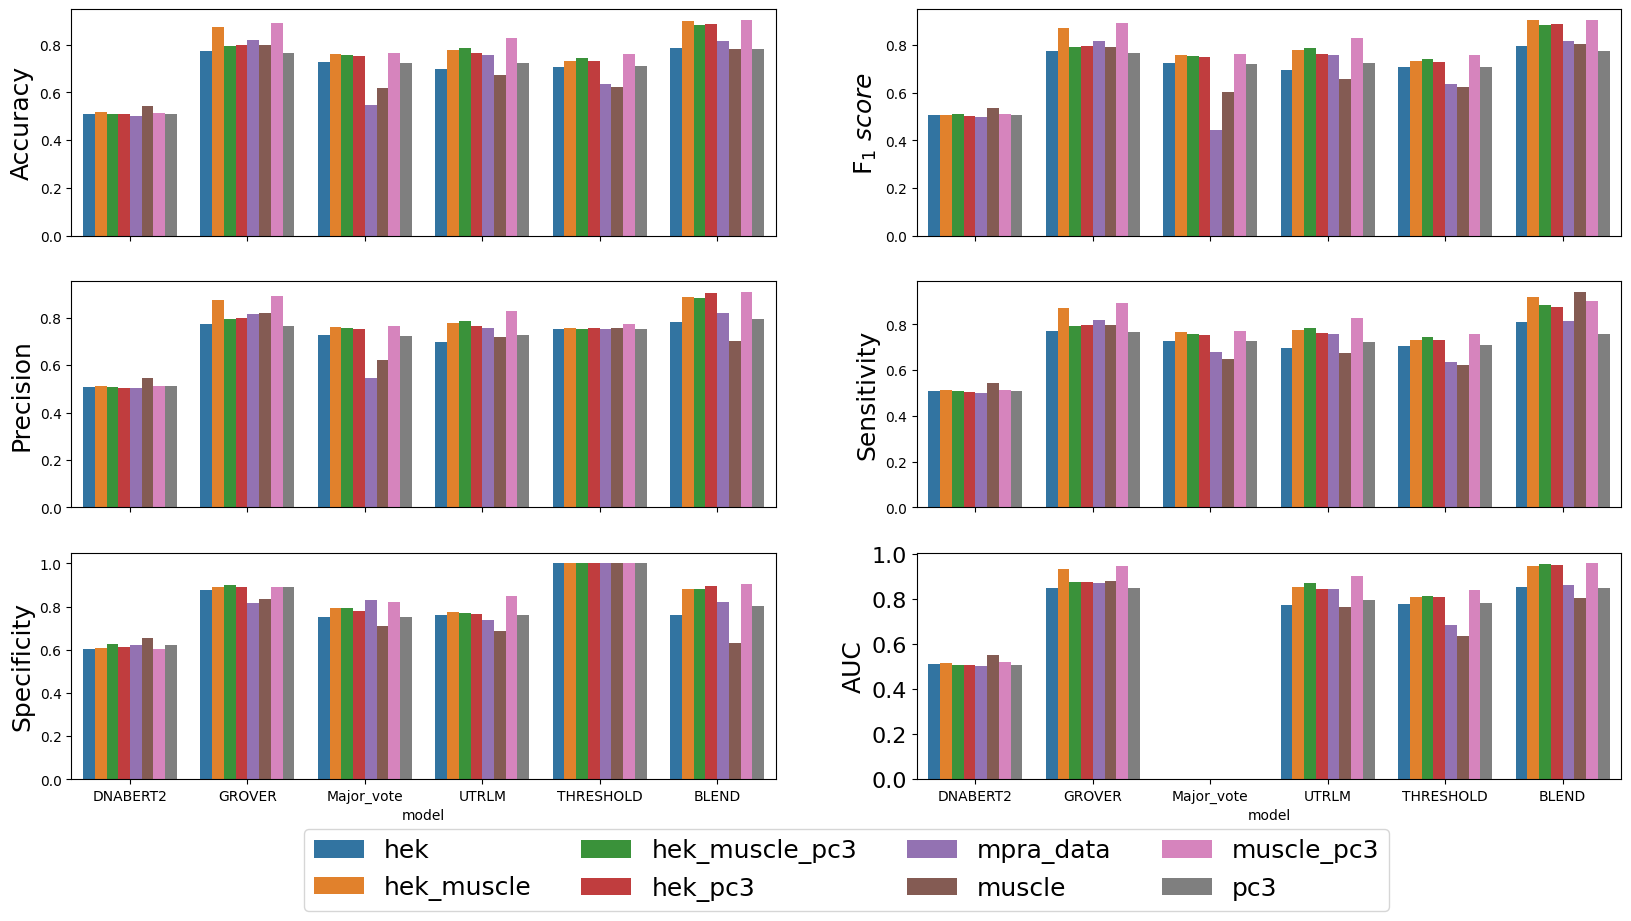

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10), sharex=True)
r,c=0,0
plt.suptitle('')
for perf in ['accuracy', 'f1', 'precision', 'recall', 'TNR', 'auc']:
    tmp = df_all[['model', 'test_on', perf]]

    if r==0 and c==1:
        sns.barplot(data=tmp, x='model', y=perf, hue='test_on', ax=ax[r][c])
        ax[r][c].legend(bbox_to_anchor=(-0.1, -2.8), loc='center', borderaxespad=0., ncol=4, fontsize=18)
    else:
        sns.barplot(data=tmp, x='model', y=perf, hue='test_on', ax=ax[r][c], legend=None)
    
    ax[r][c].set_title('')
    if perf=='f1':
        ax[r][c].set_ylabel("F$_1~score$", fontsize=18)
    elif perf=='TNR':
        ax[r][c].set_ylabel('Specificity', fontsize=18)
    elif perf == 'recall':
        ax[r][c].set_ylabel('Sensitivity', fontsize=18)
    elif perf == 'auc':
        ax[r][c].set_ylabel(perf.upper(), fontsize=18)
    else:
        ax[r][c].set_ylabel(perf.capitalize(), fontsize=18)
    c+=1
    if c==2:
        r+=1
        c=0
plt.yticks(fontsize=16)
plt.show()


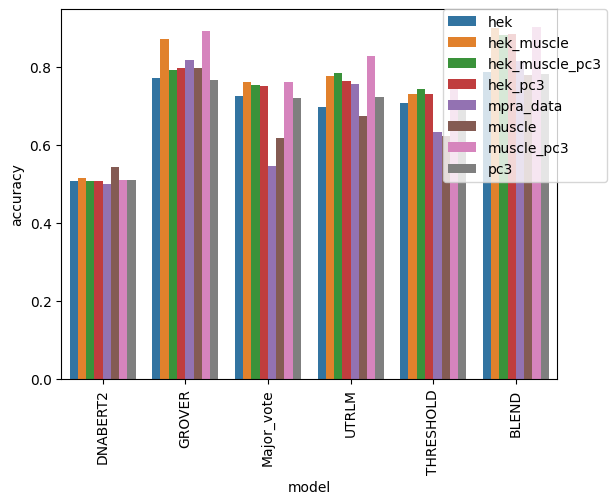